OP.GG Game Big Data Hackathon
=============

프로젝트 진행 순서
-------------
* API를 이용, Game Data를 수집.
* 수집한 Data를 분석, 방향성을 확립.
* 진행하게될 분석방향에 맞추어 Data preprocessing.
* Data analysis
* 결과 도출, 활용 방안 제시


In [3]:
# 필요한 라이브러리를 import

import sys
import requests
import json
import pandas as pd
import itertools
import time
import math
import numpy as np
from flatten_dict import flatten
from flatten_dict.reducer import make_reducer
import matplotlib.pyplot as plt 
import seaborn as sns    
import torch
from torch.utils.data import  TensorDataset, DataLoader
from torch import nn, optim
import random
from glob import glob
import torch.optim as optimizer
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F

# pandas - DataFrame의 크기를 모두 표시하도록 설정

pd.options.display.max_columns = None
pd.options.display.max_rows = None

use_cuda = torch.cuda.is_available()

In [2]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 SUPER'

In [3]:
# 필요한 package들을 install

# !pip install pandas
# !pip install flatten_dict
# !pip install matplotlib
# !pip install seaborn
# !pip install torch
# !pip install tqdm

In [4]:
# riot-API 이용을 위한 api-key값

api_key = 'RGAPI-ea3bb857-9843-4a9f-bf87-a1b2973727d8'

In [5]:
# 각 tier별 game id를 가져오기 위해 url 저장

IRON_URL4='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/IRON/IV?page='
IRON_URL3='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/IRON/III?page='
IRON_URL2='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/IRON/II?page='
IRON_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/IRON/I?page='
BRONZE_URL4='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/BRONZE/IV?page='
BRONZE_URL3='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/BRONZE/III?page='
BRONZE_URL2='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/BRONZE/II?page='
BRONZE_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/BRONZE/I?page='
SILVER_URL4='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/SILVER/IV?page='
SILVER_URL3='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/SILVER/III?page='
SILVER_URL2='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/SILVER/II?page='
SILVER_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/SILVER/I?page='
GOLD_URL4='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/GOLD/IV?page='
GOLD_URL3='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/GOLD/III?page='
GOLD_URL2='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/GOLD/II?page='
GOLD_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/GOLD/I?page='
PLATINUM_URL4='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/PLATINUM/IV?page='
PLATINUM_URL3='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/PLATINUM/III?page='
PLATINUM_URL2='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/PLATINUM/II?page='
PLATINUM_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/PLATINUM/I?page='
DIAMOND_URL4='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/DIAMOND/IV?page='
DIAMOND_URL3='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/DIAMOND/III?page='
DIAMOND_URL2='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/DIAMOND/II?page='
DIAMOND_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/DIAMOND/I?page='
MASTER_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/MASTER/I?page='
GRANDMASTER_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/GRANDMASTER/I?page='
CHALLENGER_URL1='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/CHALLENGER/I?page='

# match의 정보를 가져오기 위한 url저장
MATCH_URL = 'https://kr.api.riotgames.com/lol/match/v4/matches/'

In [7]:
# tier의 urel과 api-key를 입력하여 summonerId를 반환받음 return - array

def summonersT(tier_url, api_key):
    print('Summoners start-----')
    summoners = []
    tmpl = []
    try:
        for i in range(1,5):
            now = time.gmtime(time.time())
            print('min:',now.tm_min,'sec:',now.tm_sec)
            print('Waiting for summoners {}00 end...'.format(i))
            # request limit( 20 requests every 1 seconds(s) , 100 requests every 2 minutes(s) )에 대한 해결 방안으로 time.sleep 을 120이상으로 설정
            time.sleep(125)
            
            res = requests.get(tier_url+str(i), headers={"X-Riot-Token": api_key})
            tmp = json.loads(res.text)[5:105]
            tmpl.append(tmp)
            summoners.append(tmp)
            
        print('Summoners done-----')
    except:
        print('Errer in : ', tmpl)
        
    return pd.DataFrame(list(itertools.chain(*summoners)))['summonerId'].values


#  summoners(iterable)와 api-key를 입력받아 accountId를 반환 return - array

def getAccountId(summoners, api_key):
    
    print('\nAccounts start-----')
    now = time.gmtime(time.time())
    print('min:',now.tm_min,'sec:',now.tm_sec)
    
    accountS = []
    time.sleep(2)
    a = 0
    for i  in tqdm(summoners):
        # request limit( 20 requests every 1 seconds(s) , 100 requests every 2 minutes(s) )에 대한 해결 방안으로 time.sleep 을 120이상으로 설정
        if a % 20 == 0:
            time.sleep(1)
        if a % 100 == 0:
            time.sleep(122)
            
        togetSummonerId = 'https://kr.api.riotgames.com/lol/summoner/v4/summoners/'+str(i)
        res = requests.get(togetSummonerId, headers={"X-Riot-Token": api_key})
        accountS.append(json.loads(res.text))
        
        a += 1
        
    print('\nAccounts done-----')   
    
    return pd.DataFrame(accountS)['accountId'].values


# accountId(iterable)와 api-key를 입력받아 gameId를 반환 return - list

def getMatch(encryptedAccountId, api_key):
    print('\nMatchId start-----')
    a = 0
    now = time.gmtime(time.time())
    print('min:',now.tm_min,'sec:',now.tm_sec)
    objects = []
    matchIds = []
    time.sleep(2)
    for i in tqdm(encryptedAccountId):
        # request limit( 20 requests every 1 seconds(s) , 100 requests every 2 minutes(s) )에 대한 해결 방안으로 time.sleep 을 120이상으로 설정
        if a % 20 == 0:
            time.sleep(1)
        if a % 100 == 0:
            time.sleep(122)
            
        togetMatchOb = 'https://kr.api.riotgames.com/lol/match/v4/matchlists/by-account/{}?endIndex=1&beginIndex=0'.format(str(i))
        res = requests.get(togetMatchOb, headers={"X-Riot-Token": api_key})
        ob = pd.DataFrame(json.loads(res.text))
        
        # data의 양이 많아서 인지, Gateway timeout의 오류를 받아오는 경우 시간을 주어, 다시 받아올 수 있도록 설정
        if 'matches' in list(ob):
            objects.append(pd.DataFrame(ob)['matches'].values[0])
        else:
            print(ob)
            print("-Error recovery time-")
            time.sleep(90)
            rest=getMatchRe([i], api_key)
            matchIds.append(rest)
            print("-Error fixed-")
        a += 1
    matchIds = matchIds + list(pd.DataFrame(objects)['gameId'].values)
    
    print('\nMatchId done-----')   
    return matchIds


# getMatch중 timeout 오류발생시 다시 request를받기위해 시간간격을 두고 다시 request하도록 함.

def getMatchRe(encryptedAccountId, api_key):
    now = time.gmtime(time.time())
    print('min:',now.tm_min,'sec:',now.tm_sec)
    objects = []
    matchIds = []
    time.sleep(2)
    
    for i in tqdm(encryptedAccountId):
        togetMatchOb = 'https://kr.api.riotgames.com/lol/match/v4/matchlists/by-account/{}?endIndex=1&beginIndex=0'.format(str(i))
        res = requests.get(togetMatchOb, headers={"X-Riot-Token": api_key})
        ob = pd.DataFrame(json.loads(res.text))
        
        if 'matches' in list(ob):
            objects.append(pd.DataFrame(ob)['matches'].values[0])
        else:
            print(ob)
            print("----Error recovery time----")
            time.sleep(90)
            rest=getMatchRe([i], api_key)
            matchIds.append(rest)
    matchIds = matchIds + list(pd.DataFrame(objects)['gameId'].values)
    
    return matchIds[0]


# tier와 api-key를 입력하면 gameId를 반환하는 함수

def getMatchId(tier, api_key):
    summoners = summonersT(tier, api_key)
    accountId = getAccountId(summoners, api_key)
    gameId = getMatch(accountId, api_key)
    print("Done !!")
    return gameId

### Get Iron games

In [14]:
iron_4_gameId = getMatchId(IRON_URL4, api_key)
np.save('gameId/iron/iron_4_gameId_1', iron_4_gameId)
iron_3_gameId = getMatchId(IRON_URL3, api_key)
np.save('gameId/iron/iron_3_gameId_1', iron_3_gameId)
iron_2_gameId = getMatchId(IRON_URL2, api_key)
np.save('gameId/iron/iron_2_gameId_1', iron_2_gameId)
iron_1_gameId = getMatchId(IRON_URL1, api_key)
np.save('gameId/iron/iron_1_gameId_1', iron_1_gameId)



Summoners start-----
min: 43 sec: 14
Waiting for summoners end...
Summoners done-----

Accounts start-----
min: 45 sec: 19


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 55 sec: 15


  0%|          | 0/400 [00:00<?, ?it/s]

                      status
message      Gateway timeout
status_code              504
-Error recovery time-
min: 4 sec: 42


  0%|          | 0/1 [00:00<?, ?it/s]

-Error fixed-
                      status
message      Gateway timeout
status_code              504
-Error recovery time-
min: 8 sec: 56


  0%|          | 0/1 [00:00<?, ?it/s]

-Error fixed-

MatchId done-----
Done !!


### Get Bronze games

In [ ]:
bronze_4_gameId = getMatchId(BRONZE_URL4, api_key)
np.save('gameId/bronze/bronze_4_gameId_1', bronze_4_gameId)
bronze_3_gameId = getMatchId(BRONZE_URL3, api_key)
np.save('gameId/bronze/bronze_3_gameId_1', bronze_3_gameId)
bronze_2_gameId = getMatchId(BRONZE_URL2, api_key)
np.save('gameId/bronze/bronze_2_gameId_1', bronze_2_gameId)
bronze_1_gameId = getMatchId(BRONZE_URL1, api_key)
np.save('gameId/bronze/bronze_1_gameId_1', bronze_1_gameId)

### Get Silver games

In [ ]:
silver_4_gameId = getMatchId(SILVER_URL4, api_key)
np.save('gameId/silver/silver_4_gameId_1', silver_4_gameId)
silver_3_gameId = getMatchId(SILVER_URL3, api_key)
np.save('gameId/silver/silver_3_gameId_1', silver_3_gameId)
silver_2_gameId = getMatchId(SILVER_URL2, api_key)
np.save('gameId/silver/silver_2_gameId_1', silver_2_gameId)
silver_1_gameId = getMatchId(SILVER_URL1, api_key)
np.save('gameId/silver/silver_1_gameId_1', silver_1_gameId)

### Get Gold games

In [8]:
gold_4_gameId = getMatchId(GOLD_URL4, api_key)
np.save('gameId/gold/gold_4_gameId_1', gold_4_gameId)
gold_3_gameId = getMatchId(GOLD_URL3, api_key)
np.save('gameId/gold/gold_3_gameId_1', gold_3_gameId)
gold_2_gameId = getMatchId(GOLD_URL2, api_key)
np.save('gameId/gold/gold_2_gameId_1', gold_2_gameId)
gold_1_gameId = getMatchId(GOLD_URL1, api_key)
np.save('gameId/gold/gold_1_gameId_1', gold_1_gameId)


Summoners start-----
min: 2 sec: 23
Waiting for summoners 100 end...
min: 4 sec: 29
Waiting for summoners 200 end...
min: 6 sec: 34
Waiting for summoners 300 end...
min: 8 sec: 39
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 10 sec: 45


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 20 sec: 41


  0%|          | 0/400 [00:00<?, ?it/s]

                      status
message      Gateway timeout
status_code              504
-Error recovery time-
min: 27 sec: 28


  0%|          | 0/1 [00:00<?, ?it/s]

-Error fixed-

MatchId done-----
Done !!
Summoners start-----
min: 33 sec: 8
Waiting for summoners 100 end...
min: 35 sec: 14
Waiting for summoners 200 end...
min: 37 sec: 19
Waiting for summoners 300 end...
min: 39 sec: 24
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 41 sec: 29


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 51 sec: 29


  0%|          | 0/400 [00:00<?, ?it/s]


MatchId done-----
Done !!
Summoners start-----
min: 2 sec: 22
Waiting for summoners 100 end...
min: 4 sec: 28
Waiting for summoners 200 end...
min: 6 sec: 33
Waiting for summoners 300 end...
min: 8 sec: 38
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 10 sec: 44


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 20 sec: 41


  0%|          | 0/400 [00:00<?, ?it/s]


MatchId done-----
Done !!


### Get platinum games

In [ ]:
platinum_4_gameId = getMatchId(PLATINUM_URL4, api_key)
np.save('gameId/platinum/platinum_4_gameId_1', platinum_4_gameId)
platinum_3_gameId = getMatchId(PLATINUM_URL3, api_key)
np.save('gameId/platinum/platinum_3_gameId_1', platinum_3_gameId)
platinum_2_gameId = getMatchId(PLATINUM_URL2, api_key)
np.save('gameId/platinum/platinum_2_gameId_1', platinum_2_gameId)
platinum_1_gameId = getMatchId(PLATINUM_URL1, api_key)
np.save('gameId/platinum/platinum_1_gameId_1', platinum_1_gameId)

### Get diamond, Master, GrandMaster, challenger games

In [9]:
diamond_4_gameId = getMatchId(DIAMOND_URL4, api_key)
np.save('gameId/diamond/diamond_4_gameId_1', diamond_4_gameId)
diamond_3_gameId = getMatchId(DIAMOND_URL3, api_key)
np.save('gameId/diamond/diamond_3_gameId_1', diamond_3_gameId)
diamond_2_gameId = getMatchId(DIAMOND_URL2, api_key)
np.save('gameId/diamond/diamond_2_gameId_1', diamond_2_gameId)
diamond_1_gameId = getMatchId(DIAMOND_URL1, api_key)
np.save('gameId/diamond/diamond_1_gameId_1', diamond_1_gameId)
master_gameId = getMatchId(MASTER_URL1, api_key)
np.save('gameId/master/master_gameId_1', master_gameId)
grandmaster_gameId = getMatchId(GRANDMASTER_URL1, api_key)
np.save('gameId/grandmaster/grandmaster_gameId_1', grandmaster_gameId)
challenger_gameId = getMatchId(CHALLENGER_URL1, api_key)
np.save('gameId/challenger/challenger_gameId_1', challenger_gameId)

Summoners start-----
min: 37 sec: 43
Waiting for summoners 100 end...
min: 39 sec: 48
Waiting for summoners 200 end...
min: 41 sec: 53
Waiting for summoners 300 end...
min: 43 sec: 59
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 46 sec: 4


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 56 sec: 4


  0%|          | 0/400 [00:00<?, ?it/s]


MatchId done-----
Done !!
Summoners start-----
min: 7 sec: 0
Waiting for summoners 100 end...
min: 9 sec: 6
Waiting for summoners 200 end...
min: 11 sec: 11
Waiting for summoners 300 end...
min: 13 sec: 16
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 15 sec: 22


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 25 sec: 20


  0%|          | 0/400 [00:00<?, ?it/s]


MatchId done-----
Done !!
Summoners start-----
min: 36 sec: 17
Waiting for summoners 100 end...
min: 38 sec: 22
Waiting for summoners 200 end...
min: 40 sec: 27
Waiting for summoners 300 end...
min: 42 sec: 33
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 44 sec: 38


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 54 sec: 37


  0%|          | 0/400 [00:00<?, ?it/s]


MatchId done-----
Done !!
Summoners start-----
min: 5 sec: 30
Waiting for summoners 100 end...
min: 7 sec: 35
Waiting for summoners 200 end...
min: 9 sec: 40
Waiting for summoners 300 end...
min: 11 sec: 46
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 13 sec: 51


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 23 sec: 49


  0%|          | 0/400 [00:00<?, ?it/s]


MatchId done-----
Done !!
Summoners start-----
min: 34 sec: 47
Waiting for summoners 100 end...
min: 36 sec: 53
Waiting for summoners 200 end...
min: 38 sec: 58
Waiting for summoners 300 end...
min: 41 sec: 3
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 43 sec: 9


  0%|          | 0/400 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 53 sec: 8


  0%|          | 0/400 [00:00<?, ?it/s]

                      status
message      Gateway timeout
status_code              504
-Error recovery time-
min: 59 sec: 33


  0%|          | 0/1 [00:00<?, ?it/s]

-Error fixed-

MatchId done-----
Done !!
Summoners start-----
min: 5 sec: 39
Waiting for summoners 100 end...
min: 7 sec: 44
Waiting for summoners 200 end...
min: 9 sec: 50
Waiting for summoners 300 end...
min: 11 sec: 55
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 14 sec: 0


  0%|          | 0/182 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 18 sec: 56


  0%|          | 0/182 [00:00<?, ?it/s]


MatchId done-----
Done !!
Summoners start-----
min: 24 sec: 18
Waiting for summoners 100 end...
min: 26 sec: 24
Waiting for summoners 200 end...
min: 28 sec: 29
Waiting for summoners 300 end...
min: 30 sec: 34
Waiting for summoners 400 end...
Summoners done-----

Accounts start-----
min: 32 sec: 39


  0%|          | 0/100 [00:00<?, ?it/s]


Accounts done-----

MatchId start-----
min: 35 sec: 10


  0%|          | 0/100 [00:00<?, ?it/s]


MatchId done-----
Done !!


# Make DataFrame

In [ ]:
# 

def gameIdLoader(path, api_key):
    gameIds = np.load(path)
    matches=[]
    a = 0
    for i in tqdm(gameIds):
        # request limit( 20 requests every 1 seconds(s) , 100 requests every 2 minutes(s) )에 대한 해결 방안으로 time.sleep 을 120이상으로 설정
        if a % 20 == 0:
            time.sleep(2)
        if a % 100 == 0:
            time.sleep(125)
        load_url = MATCH_URL + str(i)
        res = requests.get(load_url, headers={"X-Riot-Token": api_key})
        ob=json.loads(res.text)
        if 'gameDuration' in ob:
            if ob['gameMode'] != 'CLASSIC':
                a += 1
                continue
            matches.append(ob)
        else:
            print(ob)
            print("-Error recovery time-")
            time.sleep(90)
            rest=gameIdLoaderRe([i], api_key)
            matches.append(rest[0])
            print("-Error fixed-")
        a += 1
    return matches
    
    
def gameIdLoaderRe(gameIds, api_key):
    matches=[]
    for i in tqdm(gameIds):
        load_url = MATCH_URL + str(i)
        res = requests.get(load_url, headers={"X-Riot-Token": api_key})
        ob=json.loads(res.text)
        if 'gameDuration' in ob:
            matches.append(ob)
        else:
            print(ob)
            print("-Error recovery time-")
            time.sleep(90)
            rest=gameIdLoaderRe([i], api_key)
            matches.append(rest[0])
            print("-Error fixed-")
    return matches
    
    
def flatter(matches):
    matchlist = []
    for i in matches:
        matchlist.append(flatten(i, enumerate_types=(list,), reducer=make_reducer(delimiter='_')))
    
    return matchlist


def filter_dict(d, f):
    ''' Filters dictionary d by function f. '''
    newDict = dict()
    # Iterate over all (k,v) pairs in names
    for key, value in d.items():
        # Is condition satisfied?
        if f(key, value):
            newDict[key] = value
    return newDict


def filter_team_dict(d, f):
    ''' Filters dictionary d by function f. '''
    newDict = dict()
    # Iterate over all (k,v) pairs in names
    ind = -1
    kl = ['teams_win', 'teams_firstBlood', 'teams_firstTower', 'teams_firstInhibitor', 'teams_firstBaron', 'teams_firstDragon', 'teams_firstRiftHerald', 'teams_towerKills', 'teams_inhibitorKills', 'teams_baronKills', 'teams_dragonKills', 'teams_riftHeraldKills']
    for key, value in d.items():
        # Is condition satisfied?
        if f(key, value):
            ind += 1
            newDict[kl[ind]] = value
    return newDict


def filter_participant_dict(d, f):
    ''' Filters dictionary d by function f. '''
    newDict = dict()
    # Iterate over all (k,v) pairs in names
    for key, value in d.items():
        # Is condition satisfied?
        if f(key, value):
            pkey = 'total_'+key[14:]
            newDict[pkey] = value
    return newDict


def winTeams_0(match):
    matchtemp = match
    
    for delstring in ['item', 'Id', 'playerScore', 'perk', 'Perk', 'bans', 'PlayerScore', 'timeline_csDiffPerMinDeltas_0-10', 'stats_totalScoreRank', 'dominionVictoryScore', 'stats_win', 'stats_unrealKills', 'stats_sightWardsBoughtInGame', 'timeline', 'vilemawKills', 'dominionVictoryScore','stats_firstInhibitorAssist','stats_firstInhibitorKill', 'stats_firstTowerAssist', 'stats_firstTowerKill', 'stats_firstBloodAssist', 'stats_firstBloodKill','turretKills','towerKills', 'damageDealtToTurrets']: 
        temp = list(filter_dict(match, lambda k,v: delstring in k).keys())
        for i in temp:
            del(matchtemp[i])
    
    
    avg_data = (np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_0' in k).values())) 
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_1' in k).values())) 
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_2' in k).values())) 
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_3' in k).values()))
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_4' in k).values())))
    avg_label = list(filter_participant_dict(matchtemp, lambda k,v: 'participants_0' in k).keys())
    win = {avg_label[i]: avg_data[i] for i in range(len(avg_label))}
    
    
    avg_data = (np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_5' in k).values())) 
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_6' in k).values())) 
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_7' in k).values())) 
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_8' in k).values()))
    + np.array(list(filter_participant_dict(matchtemp, lambda k,v: 'participants_9' in k).values())))
    lose = {avg_label[i]: avg_data[i] for i in range(len(avg_label))}
    
    win.update(filter_team_dict(matchtemp, lambda k,v: 'teams_0' in k))
    lose.update(filter_team_dict(matchtemp, lambda k,v: 'teams_1' in k))
    
    return [win, lose]


def winTeams_1(match):
    temp = winTeams_0(match)
    return [temp[1], temp[0]]


def divideTeams(matches):
    resultList = list()
    for i in matches:
        loseDict = dict()
        winDict = dict()
        loseDict.update({'gameDuration':i['gameDuration']})
        winDict.update({'gameDuration':i['gameDuration']})
        loseDict.update({'gameMode':i['gameMode']})
        winDict.update({'gameMode':i['gameMode']})
        
        if i['teams_0_win'] == 'Win':
            winDict.update(winTeams_0(i)[0])
            loseDict.update(winTeams_0(i)[1])
        else:
            winDict.update(winTeams_1(i)[0])
            loseDict.update(winTeams_1(i)[1])
        resultList.append(winDict)
        resultList.append(loseDict)
    return resultList   


def preprocessing(matches):
    df = pd.DataFrame(divideTeams(flatter(matches)))
    df["teams_firstBlood"] = df["teams_firstBlood"].astype(int)
    df["teams_firstTower"] = df["teams_firstTower"].astype(int)
    df["teams_firstInhibitor"] = df["teams_firstInhibitor"].astype(int)
    df["teams_firstBaron"] = df["teams_firstBaron"].astype(int)
    df["teams_firstDragon"] = df["teams_firstDragon"].astype(int)
    df["teams_firstRiftHerald"] = df["teams_firstRiftHerald"].astype(int)
    df.insert(0, 'team_win', df.teams_win)
    df = df.drop(columns=['teams_win', 'gameMode'])
    df['team_win'] = df['team_win'].replace(['Win','Fail'],[10000,-500])
    return df


def getDataFrame(path, api_key):
    return preprocessing(gameIdLoader(path, api_key))


In [ ]:
df = getDataFrame('gameId/iron/iron_1_gameId_1.npy', api_key)
df1 = getDataFrame('gameId/iron/iron_2_gameId_1.npy', api_key)
df2 = getDataFrame('gameId/iron/iron_3_gameId_1.npy', api_key)
df3 = getDataFrame('gameId/iron/iron_4_gameId_1.npy', api_key)

df = df.append(df1)
df = df.append(df2)
df = df.append(df3)
df.to_csv("dataFrame/iron.csv")

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

In [93]:
df_iron = pd.read_csv('dataFrame/iron.csv')
df_iron.corr().team_win

Unnamed: 0                                     -0.002556
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.446040
total__stats_deaths                            -0.444560
total__stats_assists                            0.356057
total__stats_largestKillingSpree                0.624212
total__stats_largestMultiKill                   0.423115
total__stats_killingSprees                      0.397677
total__stats_longestTimeSpentLiving             0.127642
total__stats_doubleKills                        0.402716
total__stats_tripleKills                        0.266880
total__stats_quadraKills                        0.149036
total__stats_pentaKills                         0.073797
total__stats_totalDamageDealt                   0.180327
total__stats_magicDamageDealt                   0.117886
total__stats_physicalDamageDealt                0.165830
total__stats_trueDamageDealt   

In [ ]:
df_bronze = getDataFrame('gameId/bronze/bronze_1_gameId_1.npy', api_key)
df1 = getDataFrame('gameId/bronze/bronze_2_gameId_1.npy', api_key)
df2 = getDataFrame('gameId/bronze/bronze_3_gameId_1.npy', api_key)
df3 = getDataFrame('gameId/bronze/bronze_4_gameId_1.npy', api_key)

df_bronze = df_bronze.append(df1)
df_bronze = df_bronze.append(df2)
df_bronze = df_bronze.append(df3)
df_bronze.to_csv("dataFrame/bronze.csv")

In [12]:
df_bronze = pd.read_csv('dataFrame/bronze.csv')
df_bronze.corr().team_win

Unnamed: 0                                     -0.002359
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.463172
total__stats_deaths                            -0.461522
total__stats_assists                            0.378639
total__stats_largestKillingSpree                0.615208
total__stats_largestMultiKill                   0.422129
total__stats_killingSprees                      0.420435
total__stats_longestTimeSpentLiving             0.130406
total__stats_doubleKills                        0.418660
total__stats_tripleKills                        0.278756
total__stats_quadraKills                        0.155063
total__stats_pentaKills                         0.096791
total__stats_totalDamageDealt                   0.190049
total__stats_magicDamageDealt                   0.104656
total__stats_physicalDamageDealt                0.186112
total__stats_trueDamageDealt   

In [ ]:
df_silver = getDataFrame('gameId/silver/silver_1_gameId_1.npy', api_key)
df1 = getDataFrame('gameId/silver/silver_2_gameId_1.npy', api_key)
df2 = getDataFrame('gameId/silver/silver_3_gameId_1.npy', api_key)
df3 = getDataFrame('gameId/silver/silver_4_gameId_1.npy', api_key)

df_silver = df_silver.append(df1)
df_silver = df_silver.append(df2)
df_silver = df_silver.append(df3)
df_silver.to_csv("dataFrame/silver.csv")

In [13]:
df_silver = pd.read_csv('dataFrame/silver.csv')
df_silver.corr().team_win

Unnamed: 0                                     -0.002419
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.495628
total__stats_deaths                            -0.494100
total__stats_assists                            0.406924
total__stats_largestKillingSpree                0.644412
total__stats_largestMultiKill                   0.427643
total__stats_killingSprees                      0.451219
total__stats_longestTimeSpentLiving             0.161896
total__stats_doubleKills                        0.437478
total__stats_tripleKills                        0.269764
total__stats_quadraKills                        0.159882
total__stats_pentaKills                         0.050876
total__stats_totalDamageDealt                   0.196837
total__stats_magicDamageDealt                   0.128617
total__stats_physicalDamageDealt                0.180434
total__stats_trueDamageDealt   

In [12]:
df_gold = getDataFrame('gameId/gold/gold_1_gameId_1.npy', api_key)
df1 = getDataFrame('gameId/gold/gold_2_gameId_1.npy', api_key)
df2 = getDataFrame('gameId/gold/gold_3_gameId_1.npy', api_key)
df3 = getDataFrame('gameId/gold/gold_4_gameId_1.npy', api_key)

df_gold = df_gold.append(df1)
df_gold = df_gold.append(df2)
df_gold = df_gold.append(df3)
df_gold.to_csv("dataFrame/gold.csv")

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-


  0%|          | 0/1 [00:00<?, ?it/s]

-Error fixed-
{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-


  0%|          | 0/1 [00:00<?, ?it/s]

-Error fixed-


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
df_gold = pd.read_csv('dataFrame/gold.csv')
df_gold.corr().team_win

Unnamed: 0                                     -0.002682
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.514884
total__stats_deaths                            -0.513480
total__stats_assists                            0.455093
total__stats_largestKillingSpree                0.640875
total__stats_largestMultiKill                   0.453300
total__stats_killingSprees                      0.466783
total__stats_longestTimeSpentLiving             0.149126
total__stats_doubleKills                        0.443095
total__stats_tripleKills                        0.290195
total__stats_quadraKills                        0.142252
total__stats_pentaKills                         0.073648
total__stats_totalDamageDealt                   0.210460
total__stats_magicDamageDealt                   0.171294
total__stats_physicalDamageDealt                0.174599
total__stats_trueDamageDealt   

In [ ]:
df_platinum = getDataFrame('gameId/platinum/platinum_1_gameId_1.npy', api_key)
df1 = getDataFrame('gameId/platinum/platinum_2_gameId_1.npy', api_key)
df2 = getDataFrame('gameId/platinum/platinum_3_gameId_1.npy', api_key)
df3 = getDataFrame('gameId/platinum/platinum_4_gameId_1.npy', api_key)

df_platinum = df_platinum.append(df1)
df_platinum = df_platinum.append(df2)
df_platinum = df_platinum.append(df3)
df_platinum.to_csv("dataFrame/platinum.csv")

In [8]:
df_platinum = pd.read_csv('dataFrame/platinum.csv')
df_platinum.corr().team_win

Unnamed: 0                                     -0.002443
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.507661
total__stats_deaths                            -0.506838
total__stats_assists                            0.450013
total__stats_largestKillingSpree                0.675370
total__stats_largestMultiKill                   0.468123
total__stats_killingSprees                      0.467092
total__stats_longestTimeSpentLiving             0.119070
total__stats_doubleKills                        0.473167
total__stats_tripleKills                        0.284312
total__stats_quadraKills                        0.132611
total__stats_pentaKills                         0.057102
total__stats_totalDamageDealt                   0.208308
total__stats_magicDamageDealt                   0.159175
total__stats_physicalDamageDealt                0.171298
total__stats_trueDamageDealt   

In [8]:
df_diamond = getDataFrame('gameId/diamond/diamond_3_gameId_1.npy', api_key)
df3 = getDataFrame('gameId/diamond/diamond_2_gameId_1.npy', api_key)
df4 = getDataFrame('gameId/diamond/diamond_4_gameId_1.npy', api_key)

df_over_diamond = getDataFrame('gameId/diamond/diamond_1_gameId_1.npy', api_key)
df2 = getDataFrame('gameId/master/master_gameId_1.npy', api_key)
df1 = getDataFrame('gameId/grandmaster/grandmaster_gameId_1.npy', api_key)
df0 = getDataFrame('gameId/challenger/challenger_gameId_1.npy', api_key)


df_over_diamond = df_over_diamond.append(df0)
df_over_diamond = df_over_diamond.append(df1)
df_over_diamond = df_over_diamond.append(df2)


df_diamond = df_diamond.append(df3)
df_diamond = df_diamond.append(df4)

df_over_diamond.to_csv("dataFrame/over_diamond.csv")
df_diamond.to_csv("dataFrame/diamond.csv")

 61%|████████████████████████████████████████████████▌                               | 243/400 [08:05<01:38,  1.59it/s]

{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-



 61%|███████████████████████████████████████████████▌                              | 244/400 [09:35<1:11:55, 27.66s/it]

-Error fixed-


 17%|█████████████▉                                                                   | 69/400 [02:39<02:04,  2.65it/s]

{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-



 18%|█████████████▊                                                                 | 70/400 [04:09<2:31:12, 27.49s/it]

-Error fixed-


 75%|████████████████████████████████████████████████████████████                    | 300/400 [10:03<00:34,  2.93it/s]

{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-



 75%|██████████████████████████████████████████████████████████▋                   | 301/400 [13:41<1:48:14, 65.60s/it]

-Error fixed-


 96%|█████████████████████████████████████████████████████████████████████████████   | 385/400 [14:18<00:07,  2.01it/s]

{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-



 96%|█████████████████████████████████████████████████████████████████████████████▏  | 386/400 [15:49<06:25, 27.56s/it]

-Error fixed-


 78%|██████████████████████████████████████████████████████████████▌                 | 313/400 [10:39<01:16,  1.14it/s]

{'status': {'message': 'Gateway timeout', 'status_code': 504}}
-Error recovery time-



 78%|██████████████████████████████████████████████████████████████▊                 | 314/400 [12:10<39:52, 27.82s/it]

-Error fixed-


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [12:48<00:00,  1.92s/it]


In [5]:
df_diamond = pd.read_csv('dataFrame/diamond.csv')
df_diamond.corr().team_win

Unnamed: 0                                     -0.002562
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.511407
total__stats_deaths                            -0.511052
total__stats_assists                            0.450335
total__stats_largestKillingSpree                0.668448
total__stats_largestMultiKill                   0.474543
total__stats_killingSprees                      0.472840
total__stats_longestTimeSpentLiving             0.108053
total__stats_doubleKills                        0.469813
total__stats_tripleKills                        0.292903
total__stats_quadraKills                        0.161590
total__stats_pentaKills                         0.092734
total__stats_totalDamageDealt                   0.212904
total__stats_magicDamageDealt                   0.160555
total__stats_physicalDamageDealt                0.182994
total__stats_trueDamageDealt   

In [4]:
df_over_diamond = pd.read_csv('dataFrame/over_diamond.csv')
df_over_diamond.corr().team_win

Unnamed: 0                                     -0.002664
team_win                                        1.000000
gameDuration                                    0.000000
total__stats_kills                              0.572255
total__stats_deaths                            -0.571152
total__stats_assists                            0.502283
total__stats_largestKillingSpree                0.706303
total__stats_largestMultiKill                   0.520754
total__stats_killingSprees                      0.527051
total__stats_longestTimeSpentLiving             0.100834
total__stats_doubleKills                        0.513954
total__stats_tripleKills                        0.323562
total__stats_quadraKills                        0.164878
total__stats_pentaKills                         0.079276
total__stats_totalDamageDealt                   0.202735
total__stats_magicDamageDealt                   0.137698
total__stats_physicalDamageDealt                0.197055
total__stats_trueDamageDealt   

In [343]:
df_over_diamond = pd.read_csv('dataFrame/over_diamond.csv')
over = df_over_diamond.corr().team_win
df_iron = pd.read_csv('dataFrame/iron.csv')
under = df_iron.corr().team_win
print('{0:>94} {1:>51}'.format('Over_diamond', 'Iron'))
for i in range(1,len(over.keys())):
    print('{0:<43} {1:>50.3f}  {2:>50.3f}'.format(over.keys()[i] , over[i], under[i]))

                                                                                  Over_diamond                                                Iron
team_win                                                                                 1.000                                               1.000
gameDuration                                                                             0.000                                               0.000
avg__stats_kills                                                                         0.542                                               0.447
avg__stats_deaths                                                                       -0.540                                              -0.445
avg__stats_assists                                                                       0.492                                               0.357
avg__stats_largestKillingSpree                                                           0.686                        

In [275]:
def visualdf(df, tier):
    plt.figure(figsize = (15,15))
    plt.title('{}'.format(tier),fontsize=100)
    sns.heatmap(data =pd.DataFrame(df.corr().team_win), annot=True, fmt = '.2f', linewidths=.5, cmap='BrBG', vmin = -0.8, vmax = 0.8)
    plt.savefig(tier+'.png', 
        dpi=300, 
        facecolor='w', 
        edgecolor='w',
        orientation='portrait', 
        papertype=None, 
        format=None,
        transparent=False, 
        bbox_inches=None, 
        pad_inches=0.1,
        frameon=None, 
        metadata=None)

C:\Users\hyuk6\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()
C:\Users\hyuk6\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


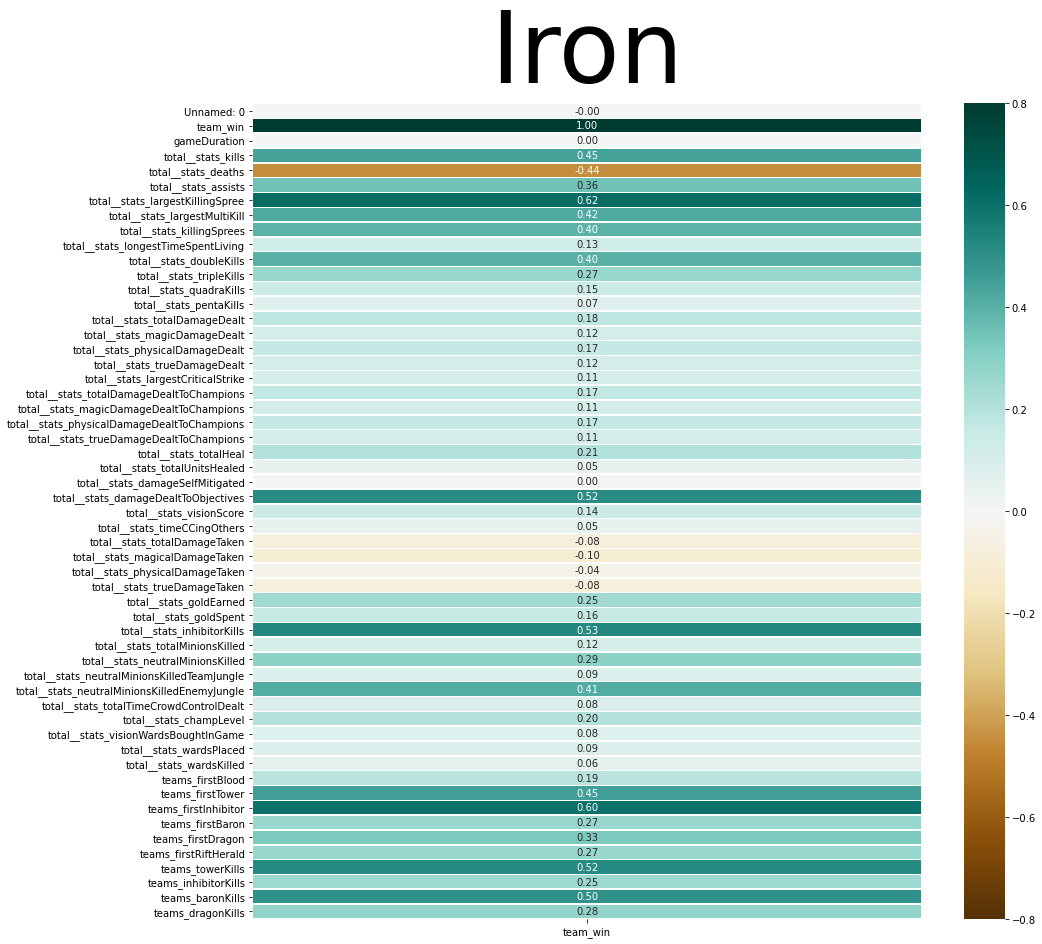

In [276]:
visualdf(df_iron, 'Iron')

<img src="visual.gif" width="900" height="600"/>

## Convert to Dataset

In [15]:
def divide_dataset():
    csvlist = np.array(glob("dataFrame/*"))
    print(csvlist)
    for i in csvlist:
        tier = i.split('\\')[-1].split('.')[-2]
        print(tier)
        df = pd.read_csv(i).drop(columns=['Unnamed: 0'])
        df['team_win'] = df['team_win'].replace([10000, -500],[1,0])
        dl = df.to_dict('records')
        tr = 6*(len(dl)//10)
        vr = 2*(len(dl)//10) + tr
        train = dl[0:tr]
        valid = dl[tr: vr]
        test = dl[vr:]
        train = pd.DataFrame(train)
        valid = pd.DataFrame(valid)
        test = pd.DataFrame(test)
        train.to_csv('dataset/'+tier+'/train/train.csv')
        valid.to_csv('dataset/'+tier+'/valid/valid.csv')
        test.to_csv('dataset/'+tier+'/test/test.csv')
    return

In [16]:
divide_dataset()

['dataFrame\\bronze.csv' 'dataFrame\\diamond.csv' 'dataFrame\\gold.csv'
 'dataFrame\\iron.csv' 'dataFrame\\over_diamond.csv'
 'dataFrame\\platinum.csv' 'dataFrame\\silver.csv']
bronze
diamond
gold
iron
over_diamond
platinum
silver


## Learning

In [261]:
def to_train_Loder(csv_url, batch_size):
    df = pd.read_csv(csv_url)
    df = df.drop(columns=['Unnamed: 0'])
    temp_dict_fail = dict()
    temp_dict_win = dict()
    
    for i in df.keys():
        temp_dict_fail[i] = 0
        temp_dict_win[i] = 0
    temp_dict_win['team_win'] = 1
    
    for i in range(10):
        df.loc[len(df.index)] = temp_dict_fail 
        df.loc[len(df.index)] = temp_dict_win
        
    label = torch.tensor(df['team_win'].values , dtype=torch.int64)
    mean = df.mean()
    std = df.std()
    df = df - mean
    df = df/std
    dd = torch.tensor(np.array(df.drop(columns=['team_win'])), dtype=torch.float32)
    ds = TensorDataset(dd, label)
    tmepLoader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    Loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return Loader , mean, std

def to_Loder(csv_url, batch_size, mean, std):
    df = pd.read_csv(csv_url)
    df = df.drop(columns=['Unnamed: 0'])
    
    temp_dict_fail = dict()
    temp_dict_win = dict()
    
    for i in df.keys():
        temp_dict_fail[i] = 0
        temp_dict_win[i] = 0
    temp_dict_win['team_win'] = 1
    
    for i in range(10):
        df.loc[len(df.index)] = temp_dict_fail 
        df.loc[len(df.index)] = temp_dict_win
        
    label = torch.tensor(df['team_win'].values , dtype=torch.int64)
    df = df - mean
    df = df/std
    dd = torch.tensor(np.array(df.drop(columns=['team_win'])), dtype=torch.float32)
    ds = TensorDataset(dd, label)
    tmepLoader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    Loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return Loader 

In [262]:
iron_train, iron_mean, iron_std= to_train_Loder('dataset/iron/train/train.csv', 128)
iron_valid = to_Loder('dataset/iron/valid/valid.csv', 128, iron_mean, iron_std)
iron_test = to_Loder('dataset/iron/test/test.csv', 128, iron_mean, iron_std)

bronze_train, bronze_mean, bronze_std = to_train_Loder('dataset/bronze/train/train.csv', 128)
bronze_valid = to_Loder('dataset/bronze/valid/valid.csv', 128, bronze_mean, bronze_std)
bronze_test = to_Loder('dataset/bronze/test/test.csv', 128, bronze_mean, bronze_std)

silver_train, silver_mean, silver_std = to_train_Loder('dataset/silver/train/train.csv', 128)
silver_valid = to_Loder('dataset/silver/valid/valid.csv', 128, silver_mean, silver_std)
silver_test = to_Loder('dataset/silver/test/test.csv', 128, silver_mean, silver_std)

gold_train, gold_mean, gold_std = to_train_Loder('dataset/gold/train/train.csv', 128)
gold_valid = to_Loder('dataset/gold/valid/valid.csv', 128, gold_mean, gold_std)
gold_test = to_Loder('dataset/gold/test/test.csv', 128, gold_mean, gold_std)

platinum_train, platinum_mean, platinum_std = to_train_Loder('dataset/platinum/train/train.csv', 128)
platinum_valid = to_Loder('dataset/platinum/valid/valid.csv', 128, platinum_mean, platinum_std)
platinum_test = to_Loder('dataset/platinum/test/test.csv', 128, platinum_mean, platinum_std)

diamond_train, diamond_mean, diamond_std = to_train_Loder('dataset/diamond/train/train.csv', 128)
diamond_valid = to_Loder('dataset/diamond/valid/valid.csv', 128, diamond_mean, diamond_std)
diamond_test = to_Loder('dataset/diamond/test/test.csv', 128, diamond_mean, diamond_std)

over_diamond_train, over_diamond_mean, over_diamond_std = to_train_Loder('dataset/over_diamond/train/train.csv', 128)
over_diamond_valid = to_Loder('dataset/over_diamond/valid/valid.csv', 128, over_diamond_mean, over_diamond_std)
over_diamond_test = to_Loder('dataset/over_diamond/test/test.csv', 128, over_diamond_mean, over_diamond_std)


In [263]:
class Network(nn.ModuleList):
    
    def __init__(self,drop):
        super(Network, self).__init__()
        self.l1 = nn.Linear(53, 30)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=drop)
        self.l2 = nn.Linear(30, 10)
        self.l3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return x

In [264]:
net_iron = Network(0.1)
net_bronze = Network(0.2)
net_silver = Network(0.1)
net_gold = Network(0.1)
net_platinum = Network(0.1)
net_diamond = Network(0.1)
net_over_diamond = Network(0.1)


if use_cuda:
    net_iron = net_iron.cuda()    
    net_bronze = net_bronze.cuda()    
    net_silver = net_silver.cuda()    
    net_gold = net_gold.cuda()    
    net_platinum = net_platinum.cuda()    
    net_diamond = net_diamond.cuda()    
    net_over_diamond = net_over_diamond.cuda()    


In [265]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, scheduler, criterion, use_cuda, save_path):
    
    # 매개변수로 전해 받은 n_epochs를 n_epoch에 저장합니다.
    n_epoch = n_epochs
    
    #plot해서 결과를 확인하기 위해 train loss와 valid loss를 저장할 list를 만들어 줍니다.
    train_losses = []
    valid_losses = []

    #가장 작은 validation loss 값을 저장하기위한 변수를 생성합니다.
    valid_loss_min = np.Inf 

    
    #training을 진행하고, validation loss 구해 보겠습니다.
    for epoch in tqdm(range(1, n_epoch+1)):
        # 확인할 train loss와 validation loss 를 생성합니다.
        train_loss = 0.0
        valid_loss = 0.0
    
        ###################
        # train the model #
        ###################

        #parameter들을 update 해야하므로, model.train()을 켜 줍니다.
        model.train()

        #train_loader에서 image와 label을 가져옵니다.
        for data, target in train_loader:
            # CUDA 가 사용 가능하다면 image와 label을 GPU로 옮깁니다.
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # gradients 값을 초기화
            optimizer.zero_grad()
            # forward pass: train_loader를 통해 가져온 batch를 model에 forward pass 시킵니다.
            output = model(data)
            # batch loss를 계산합니다.
            loss = criterion(output, target)
          
            # backward pass: gradient 값을 구합니다.
            loss.backward()
          
            # Optimizer를 돌려서 parameter들을 update합니다.
            optimizer.step()
          
            # batch별 train_loss를 더합니다.
            train_loss += loss.item()*data.size(0)
        ######################    
        # validate the model #
        ######################
        
        #parameter들을 update하지 않으므로, model.eval()을 켜 줍니다.
        model.eval()
        
        #valid_loader에서 image와 labe을 가져옵니다.
        for data, target in valid_loader:
            
            # CUDA가 사용 가능 하다면 image와 label을 GPU로 옮깁니다.
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # forward pass: valid_loader를 통해 가져온 batch를 model에 forward pass 시킵니다.
            output = model(data)
            # Validation loss를 계산합니다.
            loss = criterion(output, target)
            # batch별 Validation loss를 더합니다. 
            valid_loss += loss.item()*data.size(0)
    
        scheduler.step()
        # 각 loss 들(모두 더한값) 을 평균을 만들어 줍니다. 
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        #train_loss와 valid_loss를 위에서 생성한 losses list에 저장합니다.
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # epoch별로 train loss와 validation loss를 보여줍니다.
#         print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
        # validation loss가 가장 작은 parameter를 저장합니다.
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
    #학습된 model, 성능을 확인할 train_losses, valid_losses를 반환합니다.        
    return model, train_losses, valid_losses


In [266]:
count = 1
# count = count + 1
print('try - ',count)

try -  1


In [278]:
criterion_iron = torch.nn.CrossEntropyLoss()
optimizer_iron = optimizer.Adam(net_iron.parameters(), lr=1e-3)
scheduler_iron = StepLR(optimizer=optimizer_iron ,step_size=15, gamma=0.7)

criterion_bronze = torch.nn.CrossEntropyLoss()
optimizer_bronze = optimizer.Adam(net_bronze.parameters(), lr=1e-3)
scheduler_bronze = StepLR(optimizer=optimizer_bronze ,step_size=15, gamma=0.7)

criterion_silver = torch.nn.CrossEntropyLoss()
optimizer_silver = optimizer.Adam(net_silver.parameters(), lr=1e-3)
scheduler_silver = StepLR(optimizer=optimizer_silver ,step_size=15, gamma=0.7)

criterion_gold = torch.nn.CrossEntropyLoss()
optimizer_gold = optimizer.Adam(net_gold.parameters(), lr=1e-3)
scheduler_gold = StepLR(optimizer=optimizer_gold ,step_size=15, gamma=0.7)

criterion_platinum = torch.nn.CrossEntropyLoss()
optimizer_platinum = optimizer.Adam(net_platinum.parameters(), lr=1e-3)
scheduler_platinum = StepLR(optimizer=optimizer_platinum ,step_size=15, gamma=0.7)


criterion_diamond = torch.nn.CrossEntropyLoss()
optimizer_diamond = optimizer.Adam(net_diamond.parameters(), lr=1e-3)
scheduler_diamond = StepLR(optimizer=optimizer_diamond ,step_size=15, gamma=0.7)


criterion_over_diamond = torch.nn.CrossEntropyLoss()
optimizer_over_diamond = optimizer.Adam(net_over_diamond.parameters(), lr=1e-3)
scheduler_over_diamond = StepLR(optimizer=optimizer_over_diamond ,step_size=15, gamma=0.7)

In [279]:
use_cuda = torch.cuda.is_available()

In [269]:
epochs = 100
model_path_iron = Path("models/iron").expanduser()
save_path_iron = model_path_iron.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_iron, train_losses_iron, valid_losses_iron = train(epochs, iron_train, iron_valid, net_iron, optimizer_iron, scheduler_iron, criterion_iron, use_cuda, save_path_iron)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_iron.load_state_dict(torch.load(save_path_iron))


epochs = 100
model_path_bronze = Path("models/bronze").expanduser()
save_path_bronze = model_path_bronze.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_bronze, train_losses_bronze, valid_losses_bronze = train(epochs, bronze_train, bronze_valid, net_bronze, optimizer_bronze, scheduler_bronze, criterion_bronze, use_cuda, save_path_bronze)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_bronze.load_state_dict(torch.load(save_path_bronze))


epochs = 100
model_path_silver = Path("models/silver").expanduser()
save_path_silver = model_path_silver.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_silver, train_losses_silver, valid_losses_silver = train(epochs, silver_train, silver_valid, net_silver, optimizer_silver, scheduler_silver, criterion_silver, use_cuda, save_path_silver)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_silver.load_state_dict(torch.load(save_path_silver))


epochs = 100
model_path_gold = Path("models/gold").expanduser()
save_path_gold = model_path_gold.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_gold, train_losses_gold, valid_losses_gold = train(epochs, gold_train, gold_valid, net_gold, optimizer_gold, scheduler_gold, criterion_gold, use_cuda, save_path_gold)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_gold.load_state_dict(torch.load(save_path_gold))


epochs = 100
model_path_platinum = Path("models/platinum").expanduser()
save_path_platinum = model_path_platinum.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_platinum, train_losses_platinum, valid_losses_platinum = train(epochs, platinum_train, platinum_valid, net_platinum, optimizer_platinum, scheduler_platinum, criterion_platinum, use_cuda, save_path_platinum)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_platinum.load_state_dict(torch.load(save_path_platinum))


epochs = 100
model_path_diamond = Path("models/diamond").expanduser()
save_path_diamond = model_path_diamond.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_diamond, train_losses_diamond, valid_losses_diamond = train(epochs, diamond_train, diamond_valid, net_diamond, optimizer_diamond, scheduler_diamond, criterion_diamond, use_cuda, save_path_diamond)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_diamond.load_state_dict(torch.load(save_path_diamond))


epochs = 100
model_path_over_diamond = Path("models/over_diamond").expanduser()
save_path_over_diamond = model_path_over_diamond.joinpath("model_try_{}.pt".format(count))
# model_scratch 학습하기
model_over_diamond, train_losses_over_diamond, valid_losses_over_diamond = train(epochs, over_diamond_train, over_diamond_valid, net_over_diamond, optimizer_over_diamond, scheduler_over_diamond, criterion_over_diamond, use_cuda, save_path_over_diamond)
# validation이 가장 좋았던 모델 parameter 불러와서 저장하기
model_over_diamond.load_state_dict(torch.load(save_path_over_diamond))

  4%|███▎                                                                              | 4/100 [00:00<00:05, 16.49it/s]

Validation loss decreased (0.674255 --> 0.674255).  Saving model ...
Validation loss decreased (0.641820 --> 0.641820).  Saving model ...
Validation loss decreased (0.590431 --> 0.590431).  Saving model ...
Validation loss decreased (0.510980 --> 0.510980).  Saving model ...


  8%|██████▌                                                                           | 8/100 [00:00<00:05, 16.67it/s]

Validation loss decreased (0.411695 --> 0.411695).  Saving model ...
Validation loss decreased (0.318404 --> 0.318404).  Saving model ...
Validation loss decreased (0.256103 --> 0.256103).  Saving model ...
Validation loss decreased (0.219730 --> 0.219730).  Saving model ...


 12%|█████████▋                                                                       | 12/100 [00:00<00:05, 16.23it/s]

Validation loss decreased (0.198647 --> 0.198647).  Saving model ...
Validation loss decreased (0.186803 --> 0.186803).  Saving model ...
Validation loss decreased (0.179008 --> 0.179008).  Saving model ...
Validation loss decreased (0.174225 --> 0.174225).  Saving model ...


 16%|████████████▉                                                                    | 16/100 [00:00<00:05, 16.38it/s]

Validation loss decreased (0.171323 --> 0.171323).  Saving model ...
Validation loss decreased (0.168542 --> 0.168542).  Saving model ...
Validation loss decreased (0.164090 --> 0.164090).  Saving model ...
Validation loss decreased (0.162514 --> 0.162514).  Saving model ...


 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 15.91it/s]

Validation loss decreased (0.161125 --> 0.161125).  Saving model ...
Validation loss decreased (0.159745 --> 0.159745).  Saving model ...
Validation loss decreased (0.158033 --> 0.158033).  Saving model ...
Validation loss decreased (0.156358 --> 0.156358).  Saving model ...


 24%|███████████████████▍                                                             | 24/100 [00:01<00:04, 15.84it/s]

Validation loss decreased (0.155611 --> 0.155611).  Saving model ...
Validation loss decreased (0.153100 --> 0.153100).  Saving model ...
Validation loss decreased (0.152843 --> 0.152843).  Saving model ...


 28%|██████████████████████▋                                                          | 28/100 [00:01<00:04, 16.42it/s]

Validation loss decreased (0.148452 --> 0.148452).  Saving model ...
Validation loss decreased (0.146833 --> 0.146833).  Saving model ...


 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:03, 16.31it/s]

Validation loss decreased (0.142692 --> 0.142692).  Saving model ...
Validation loss decreased (0.142009 --> 0.142009).  Saving model ...
Validation loss decreased (0.141479 --> 0.141479).  Saving model ...


 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:02, 16.47it/s]

Validation loss decreased (0.139707 --> 0.139707).  Saving model ...


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:03<00:02, 16.35it/s]

Validation loss decreased (0.138598 --> 0.138598).  Saving model ...
Validation loss decreased (0.137455 --> 0.137455).  Saving model ...


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:03<00:02, 16.69it/s]

Validation loss decreased (0.137404 --> 0.137404).  Saving model ...
Validation loss decreased (0.136976 --> 0.136976).  Saving model ...


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:04<00:01, 15.97it/s]

Validation loss decreased (0.136771 --> 0.136771).  Saving model ...
Validation loss decreased (0.135224 --> 0.135224).  Saving model ...
Validation loss decreased (0.134464 --> 0.134464).  Saving model ...


  4%|███▎                                                                              | 4/100 [00:00<00:06, 15.92it/s]

Validation loss decreased (0.627767 --> 0.627767).  Saving model ...
Validation loss decreased (0.560236 --> 0.560236).  Saving model ...
Validation loss decreased (0.474923 --> 0.474923).  Saving model ...
Validation loss decreased (0.387911 --> 0.387911).  Saving model ...


  8%|██████▌                                                                           | 8/100 [00:00<00:06, 15.06it/s]

Validation loss decreased (0.317839 --> 0.317839).  Saving model ...
Validation loss decreased (0.266195 --> 0.266195).  Saving model ...
Validation loss decreased (0.231739 --> 0.231739).  Saving model ...
Validation loss decreased (0.208486 --> 0.208486).  Saving model ...


 12%|█████████▋                                                                       | 12/100 [00:00<00:05, 15.02it/s]

Validation loss decreased (0.192496 --> 0.192496).  Saving model ...
Validation loss decreased (0.181401 --> 0.181401).  Saving model ...
Validation loss decreased (0.175074 --> 0.175074).  Saving model ...
Validation loss decreased (0.170464 --> 0.170464).  Saving model ...


 16%|████████████▉                                                                    | 16/100 [00:01<00:05, 15.33it/s]

Validation loss decreased (0.166510 --> 0.166510).  Saving model ...
Validation loss decreased (0.162677 --> 0.162677).  Saving model ...
Validation loss decreased (0.160660 --> 0.160660).  Saving model ...
Validation loss decreased (0.158395 --> 0.158395).  Saving model ...


 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 15.29it/s]

Validation loss decreased (0.158086 --> 0.158086).  Saving model ...
Validation loss decreased (0.155282 --> 0.155282).  Saving model ...
Validation loss decreased (0.151577 --> 0.151577).  Saving model ...
Validation loss decreased (0.149351 --> 0.149351).  Saving model ...


 24%|███████████████████▍                                                             | 24/100 [00:01<00:04, 15.84it/s]

Validation loss decreased (0.149020 --> 0.149020).  Saving model ...
Validation loss decreased (0.147302 --> 0.147302).  Saving model ...
Validation loss decreased (0.145761 --> 0.145761).  Saving model ...


 30%|████████████████████████▎                                                        | 30/100 [00:01<00:04, 15.79it/s]

Validation loss decreased (0.143358 --> 0.143358).  Saving model ...


 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 15.80it/s]

Validation loss decreased (0.141110 --> 0.141110).  Saving model ...
Validation loss decreased (0.140994 --> 0.140994).  Saving model ...
Validation loss decreased (0.139519 --> 0.139519).  Saving model ...
Validation loss decreased (0.137771 --> 0.137771).  Saving model ...


 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 15.36it/s]

Validation loss decreased (0.136992 --> 0.136992).  Saving model ...
Validation loss decreased (0.136877 --> 0.136877).  Saving model ...


  4%|███▎                                                                              | 4/100 [00:00<00:06, 15.19it/s]

Validation loss decreased (0.670604 --> 0.670604).  Saving model ...
Validation loss decreased (0.617739 --> 0.617739).  Saving model ...
Validation loss decreased (0.541752 --> 0.541752).  Saving model ...
Validation loss decreased (0.441036 --> 0.441036).  Saving model ...


  8%|██████▌                                                                           | 8/100 [00:00<00:05, 16.02it/s]

Validation loss decreased (0.336020 --> 0.336020).  Saving model ...
Validation loss decreased (0.264182 --> 0.264182).  Saving model ...
Validation loss decreased (0.225369 --> 0.225369).  Saving model ...
Validation loss decreased (0.203826 --> 0.203826).  Saving model ...


 12%|█████████▋                                                                       | 12/100 [00:00<00:05, 16.42it/s]

Validation loss decreased (0.189072 --> 0.189072).  Saving model ...
Validation loss decreased (0.179698 --> 0.179698).  Saving model ...
Validation loss decreased (0.171244 --> 0.171244).  Saving model ...
Validation loss decreased (0.164597 --> 0.164597).  Saving model ...


 16%|████████████▉                                                                    | 16/100 [00:01<00:05, 15.90it/s]

Validation loss decreased (0.163800 --> 0.163800).  Saving model ...
Validation loss decreased (0.159501 --> 0.159501).  Saving model ...
Validation loss decreased (0.156212 --> 0.156212).  Saving model ...
Validation loss decreased (0.154418 --> 0.154418).  Saving model ...


 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 15.33it/s]

Validation loss decreased (0.146306 --> 0.146306).  Saving model ...
Validation loss decreased (0.143211 --> 0.143211).  Saving model ...
Validation loss decreased (0.140843 --> 0.140843).  Saving model ...
Validation loss decreased (0.139384 --> 0.139384).  Saving model ...


 24%|███████████████████▍                                                             | 24/100 [00:01<00:04, 15.21it/s]

Validation loss decreased (0.138549 --> 0.138549).  Saving model ...
Validation loss decreased (0.137767 --> 0.137767).  Saving model ...
Validation loss decreased (0.134671 --> 0.134671).  Saving model ...


 28%|██████████████████████▋                                                          | 28/100 [00:01<00:04, 14.95it/s]

Validation loss decreased (0.133172 --> 0.133172).  Saving model ...
Validation loss decreased (0.131612 --> 0.131612).  Saving model ...
Validation loss decreased (0.129113 --> 0.129113).  Saving model ...


 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 15.13it/s]

Validation loss decreased (0.128276 --> 0.128276).  Saving model ...
Validation loss decreased (0.127706 --> 0.127706).  Saving model ...


 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 14.97it/s]

Validation loss decreased (0.125376 --> 0.125376).  Saving model ...
Validation loss decreased (0.125174 --> 0.125174).  Saving model ...


 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:03, 15.24it/s]

Validation loss decreased (0.124304 --> 0.124304).  Saving model ...
Validation loss decreased (0.124287 --> 0.124287).  Saving model ...


 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 15.26it/s]

Validation loss decreased (0.123793 --> 0.123793).  Saving model ...
Validation loss decreased (0.122830 --> 0.122830).  Saving model ...


  4%|███▎                                                                              | 4/100 [00:00<00:05, 16.52it/s]

Validation loss decreased (0.655158 --> 0.655158).  Saving model ...
Validation loss decreased (0.606198 --> 0.606198).  Saving model ...
Validation loss decreased (0.542692 --> 0.542692).  Saving model ...
Validation loss decreased (0.452849 --> 0.452849).  Saving model ...


  8%|██████▌                                                                           | 8/100 [00:00<00:05, 16.19it/s]

Validation loss decreased (0.359355 --> 0.359355).  Saving model ...
Validation loss decreased (0.276404 --> 0.276404).  Saving model ...
Validation loss decreased (0.219049 --> 0.219049).  Saving model ...
Validation loss decreased (0.186618 --> 0.186618).  Saving model ...


 12%|█████████▋                                                                       | 12/100 [00:00<00:05, 16.22it/s]

Validation loss decreased (0.170533 --> 0.170533).  Saving model ...
Validation loss decreased (0.158607 --> 0.158607).  Saving model ...
Validation loss decreased (0.153824 --> 0.153824).  Saving model ...
Validation loss decreased (0.147400 --> 0.147400).  Saving model ...


 16%|████████████▉                                                                    | 16/100 [00:00<00:05, 16.10it/s]

Validation loss decreased (0.145060 --> 0.145060).  Saving model ...
Validation loss decreased (0.143167 --> 0.143167).  Saving model ...
Validation loss decreased (0.138454 --> 0.138454).  Saving model ...
Validation loss decreased (0.135618 --> 0.135618).  Saving model ...


 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 15.98it/s]

Validation loss decreased (0.134540 --> 0.134540).  Saving model ...
Validation loss decreased (0.133267 --> 0.133267).  Saving model ...
Validation loss decreased (0.128429 --> 0.128429).  Saving model ...


 26%|█████████████████████                                                            | 26/100 [00:01<00:04, 16.22it/s]

Validation loss decreased (0.125574 --> 0.125574).  Saving model ...


 31%|█████████████████████████                                                        | 31/100 [00:01<00:03, 17.38it/s]

Validation loss decreased (0.123793 --> 0.123793).  Saving model ...
Validation loss decreased (0.122167 --> 0.122167).  Saving model ...


 37%|█████████████████████████████▉                                                   | 37/100 [00:02<00:03, 16.86it/s]

Validation loss decreased (0.121487 --> 0.121487).  Saving model ...
Validation loss decreased (0.121331 --> 0.121331).  Saving model ...
Validation loss decreased (0.118237 --> 0.118237).  Saving model ...


  4%|███▎                                                                              | 4/100 [00:00<00:05, 16.63it/s]

Validation loss decreased (0.617195 --> 0.617195).  Saving model ...
Validation loss decreased (0.548306 --> 0.548306).  Saving model ...
Validation loss decreased (0.476929 --> 0.476929).  Saving model ...
Validation loss decreased (0.402753 --> 0.402753).  Saving model ...


  8%|██████▌                                                                           | 8/100 [00:00<00:05, 15.81it/s]

Validation loss decreased (0.328405 --> 0.328405).  Saving model ...
Validation loss decreased (0.266416 --> 0.266416).  Saving model ...
Validation loss decreased (0.213005 --> 0.213005).  Saving model ...
Validation loss decreased (0.176455 --> 0.176455).  Saving model ...


 10%|████████                                                                         | 10/100 [00:00<00:05, 15.49it/s]

Validation loss decreased (0.152411 --> 0.152411).  Saving model ...
Validation loss decreased (0.137450 --> 0.137450).  Saving model ...
Validation loss decreased (0.131546 --> 0.131546).  Saving model ...


 14%|███████████▎                                                                     | 14/100 [00:00<00:05, 15.10it/s]

Validation loss decreased (0.123609 --> 0.123609).  Saving model ...
Validation loss decreased (0.114459 --> 0.114459).  Saving model ...
Validation loss decreased (0.109576 --> 0.109576).  Saving model ...


 18%|██████████████▌                                                                  | 18/100 [00:01<00:05, 14.95it/s]

Validation loss decreased (0.108903 --> 0.108903).  Saving model ...
Validation loss decreased (0.107906 --> 0.107906).  Saving model ...
Validation loss decreased (0.102136 --> 0.102136).  Saving model ...


 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 15.12it/s]

Validation loss decreased (0.099961 --> 0.099961).  Saving model ...
Validation loss decreased (0.099941 --> 0.099941).  Saving model ...
Validation loss decreased (0.097117 --> 0.097117).  Saving model ...


 26%|█████████████████████                                                            | 26/100 [00:01<00:04, 14.92it/s]

Validation loss decreased (0.095783 --> 0.095783).  Saving model ...
Validation loss decreased (0.093969 --> 0.093969).  Saving model ...


 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 15.25it/s]

Validation loss decreased (0.092076 --> 0.092076).  Saving model ...
Validation loss decreased (0.090797 --> 0.090797).  Saving model ...
Validation loss decreased (0.090087 --> 0.090087).  Saving model ...
Validation loss decreased (0.089624 --> 0.089624).  Saving model ...


 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 15.84it/s]

Validation loss decreased (0.089485 --> 0.089485).  Saving model ...
Validation loss decreased (0.089091 --> 0.089091).  Saving model ...


 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:03, 15.46it/s]

Validation loss decreased (0.088399 --> 0.088399).  Saving model ...


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.15it/s]

Validation loss decreased (0.660530 --> 0.660530).  Saving model ...
Validation loss decreased (0.619412 --> 0.619412).  Saving model ...
Validation loss decreased (0.566603 --> 0.566603).  Saving model ...
Validation loss decreased (0.502763 --> 0.502763).  Saving model ...
Validation loss decreased (0.427779 --> 0.427779).  Saving model ...


  9%|███████▍                                                                          | 9/100 [00:00<00:04, 20.17it/s]

Validation loss decreased (0.350499 --> 0.350499).  Saving model ...
Validation loss decreased (0.278788 --> 0.278788).  Saving model ...
Validation loss decreased (0.219308 --> 0.219308).  Saving model ...
Validation loss decreased (0.177650 --> 0.177650).  Saving model ...
Validation loss decreased (0.151478 --> 0.151478).  Saving model ...


 15%|████████████▏                                                                    | 15/100 [00:00<00:04, 20.15it/s]

Validation loss decreased (0.134130 --> 0.134130).  Saving model ...
Validation loss decreased (0.124177 --> 0.124177).  Saving model ...
Validation loss decreased (0.113320 --> 0.113320).  Saving model ...
Validation loss decreased (0.107805 --> 0.107805).  Saving model ...
Validation loss decreased (0.105336 --> 0.105336).  Saving model ...


 18%|██████████████▌                                                                  | 18/100 [00:00<00:04, 20.12it/s]

Validation loss decreased (0.099725 --> 0.099725).  Saving model ...
Validation loss decreased (0.095634 --> 0.095634).  Saving model ...
Validation loss decreased (0.090220 --> 0.090220).  Saving model ...
Validation loss decreased (0.087729 --> 0.087729).  Saving model ...


 24%|███████████████████▍                                                             | 24/100 [00:01<00:03, 21.15it/s]

Validation loss decreased (0.083234 --> 0.083234).  Saving model ...
Validation loss decreased (0.081867 --> 0.081867).  Saving model ...
Validation loss decreased (0.080104 --> 0.080104).  Saving model ...
Validation loss decreased (0.078619 --> 0.078619).  Saving model ...


 30%|████████████████████████▎                                                        | 30/100 [00:01<00:03, 21.97it/s]

Validation loss decreased (0.076236 --> 0.076236).  Saving model ...
Validation loss decreased (0.075633 --> 0.075633).  Saving model ...
Validation loss decreased (0.073864 --> 0.073864).  Saving model ...
Validation loss decreased (0.072888 --> 0.072888).  Saving model ...


 36%|█████████████████████████████▏                                                   | 36/100 [00:01<00:02, 21.48it/s]

Validation loss decreased (0.070849 --> 0.070849).  Saving model ...
Validation loss decreased (0.070020 --> 0.070020).  Saving model ...
Validation loss decreased (0.069468 --> 0.069468).  Saving model ...


 39%|███████████████████████████████▌                                                 | 39/100 [00:01<00:02, 21.30it/s]

Validation loss decreased (0.066985 --> 0.066985).  Saving model ...
Validation loss decreased (0.066455 --> 0.066455).  Saving model ...
Validation loss decreased (0.065664 --> 0.065664).  Saving model ...
Validation loss decreased (0.063976 --> 0.063976).  Saving model ...


 45%|████████████████████████████████████▍                                            | 45/100 [00:02<00:02, 22.11it/s]

Validation loss decreased (0.061745 --> 0.061745).  Saving model ...
Validation loss decreased (0.061200 --> 0.061200).  Saving model ...
Validation loss decreased (0.060412 --> 0.060412).  Saving model ...
Validation loss decreased (0.060135 --> 0.060135).  Saving model ...
Validation loss decreased (0.060067 --> 0.060067).  Saving model ...


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:02<00:02, 21.92it/s]

Validation loss decreased (0.058831 --> 0.058831).  Saving model ...
Validation loss decreased (0.057944 --> 0.057944).  Saving model ...
Validation loss decreased (0.055495 --> 0.055495).  Saving model ...


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:02<00:02, 21.60it/s]

Validation loss decreased (0.055327 --> 0.055327).  Saving model ...
Validation loss decreased (0.055209 --> 0.055209).  Saving model ...
Validation loss decreased (0.054758 --> 0.054758).  Saving model ...
Validation loss decreased (0.053615 --> 0.053615).  Saving model ...
Validation loss decreased (0.052629 --> 0.052629).  Saving model ...


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:02<00:01, 21.05it/s]

Validation loss decreased (0.052207 --> 0.052207).  Saving model ...
Validation loss decreased (0.050541 --> 0.050541).  Saving model ...


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:03<00:01, 22.27it/s]

Validation loss decreased (0.050332 --> 0.050332).  Saving model ...
Validation loss decreased (0.049644 --> 0.049644).  Saving model ...
Validation loss decreased (0.049380 --> 0.049380).  Saving model ...
Validation loss decreased (0.048232 --> 0.048232).  Saving model ...


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:03<00:01, 22.17it/s]

Validation loss decreased (0.047186 --> 0.047186).  Saving model ...
Validation loss decreased (0.046029 --> 0.046029).  Saving model ...


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:03<00:01, 21.71it/s]

Validation loss decreased (0.045410 --> 0.045410).  Saving model ...
Validation loss decreased (0.044838 --> 0.044838).  Saving model ...


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:03<00:00, 22.16it/s]

Validation loss decreased (0.044400 --> 0.044400).  Saving model ...
Validation loss decreased (0.043959 --> 0.043959).  Saving model ...
Validation loss decreased (0.043474 --> 0.043474).  Saving model ...


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:04<00:00, 22.90it/s]

Validation loss decreased (0.043086 --> 0.043086).  Saving model ...
Validation loss decreased (0.042301 --> 0.042301).  Saving model ...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Validation loss decreased (0.041711 --> 0.041711).  Saving model ...
Validation loss decreased (0.041584 --> 0.041584).  Saving model ...
Validation loss decreased (0.041394 --> 0.041394).  Saving model ...
Validation loss decreased (0.617716 --> 0.617716).  Saving model ...
Validation loss decreased (0.570356 --> 0.570356).  Saving model ...


  6%|████▉                                                                             | 6/100 [00:00<00:04, 23.14it/s]

Validation loss decreased (0.511220 --> 0.511220).  Saving model ...
Validation loss decreased (0.438232 --> 0.438232).  Saving model ...
Validation loss decreased (0.359835 --> 0.359835).  Saving model ...
Validation loss decreased (0.286523 --> 0.286523).  Saving model ...
Validation loss decreased (0.230440 --> 0.230440).  Saving model ...


 12%|█████████▋                                                                       | 12/100 [00:00<00:03, 23.35it/s]

Validation loss decreased (0.197736 --> 0.197736).  Saving model ...
Validation loss decreased (0.167436 --> 0.167436).  Saving model ...
Validation loss decreased (0.151417 --> 0.151417).  Saving model ...
Validation loss decreased (0.139876 --> 0.139876).  Saving model ...
Validation loss decreased (0.131095 --> 0.131095).  Saving model ...


 15%|████████████▏                                                                    | 15/100 [00:00<00:03, 22.70it/s]

Validation loss decreased (0.125425 --> 0.125425).  Saving model ...
Validation loss decreased (0.119226 --> 0.119226).  Saving model ...
Validation loss decreased (0.117021 --> 0.117021).  Saving model ...
Validation loss decreased (0.111011 --> 0.111011).  Saving model ...
Validation loss decreased (0.108338 --> 0.108338).  Saving model ...


 21%|█████████████████                                                                | 21/100 [00:00<00:03, 22.36it/s]

Validation loss decreased (0.103989 --> 0.103989).  Saving model ...
Validation loss decreased (0.100632 --> 0.100632).  Saving model ...
Validation loss decreased (0.099332 --> 0.099332).  Saving model ...
Validation loss decreased (0.097508 --> 0.097508).  Saving model ...
Validation loss decreased (0.093518 --> 0.093518).  Saving model ...


 27%|█████████████████████▊                                                           | 27/100 [00:01<00:03, 23.39it/s]

Validation loss decreased (0.090797 --> 0.090797).  Saving model ...
Validation loss decreased (0.088614 --> 0.088614).  Saving model ...
Validation loss decreased (0.083689 --> 0.083689).  Saving model ...


 33%|██████████████████████████▋                                                      | 33/100 [00:01<00:02, 23.66it/s]

Validation loss decreased (0.083536 --> 0.083536).  Saving model ...
Validation loss decreased (0.082406 --> 0.082406).  Saving model ...
Validation loss decreased (0.078801 --> 0.078801).  Saving model ...


 39%|███████████████████████████████▌                                                 | 39/100 [00:01<00:02, 23.58it/s]

Validation loss decreased (0.077989 --> 0.077989).  Saving model ...
Validation loss decreased (0.073840 --> 0.073840).  Saving model ...
Validation loss decreased (0.073108 --> 0.073108).  Saving model ...
Validation loss decreased (0.070980 --> 0.070980).  Saving model ...


 45%|████████████████████████████████████▍                                            | 45/100 [00:01<00:02, 23.14it/s]

Validation loss decreased (0.069414 --> 0.069414).  Saving model ...
Validation loss decreased (0.069390 --> 0.069390).  Saving model ...
Validation loss decreased (0.067654 --> 0.067654).  Saving model ...
Validation loss decreased (0.065948 --> 0.065948).  Saving model ...


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:02<00:02, 22.85it/s]

Validation loss decreased (0.065502 --> 0.065502).  Saving model ...
Validation loss decreased (0.064602 --> 0.064602).  Saving model ...
Validation loss decreased (0.064505 --> 0.064505).  Saving model ...
Validation loss decreased (0.063709 --> 0.063709).  Saving model ...


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:02<00:01, 23.06it/s]

Validation loss decreased (0.063593 --> 0.063593).  Saving model ...
Validation loss decreased (0.062836 --> 0.062836).  Saving model ...
Validation loss decreased (0.062586 --> 0.062586).  Saving model ...
Validation loss decreased (0.061227 --> 0.061227).  Saving model ...


 63%|███████████████████████████████████████████████████                              | 63/100 [00:02<00:01, 23.49it/s]

Validation loss decreased (0.060656 --> 0.060656).  Saving model ...
Validation loss decreased (0.060485 --> 0.060485).  Saving model ...


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:02<00:01, 23.69it/s]

Validation loss decreased (0.059307 --> 0.059307).  Saving model ...


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:03<00:00, 24.66it/s]

Validation loss decreased (0.058783 --> 0.058783).  Saving model ...


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:03<00:00, 23.67it/s]

Validation loss decreased (0.058477 --> 0.058477).  Saving model ...
Validation loss decreased (0.058174 --> 0.058174).  Saving model ...
Validation loss decreased (0.058069 --> 0.058069).  Saving model ...
Validation loss decreased (0.057620 --> 0.057620).  Saving model ...


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:03<00:00, 23.67it/s]

Validation loss decreased (0.057423 --> 0.057423).  Saving model ...
Validation loss decreased (0.057052 --> 0.057052).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.62it/s]

Validation loss decreased (0.055902 --> 0.055902).  Saving model ...
Validation loss decreased (0.055872 --> 0.055872).  Saving model ...


<All keys matched successfully>

C:\Users\hyuk6\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\hyuk6\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


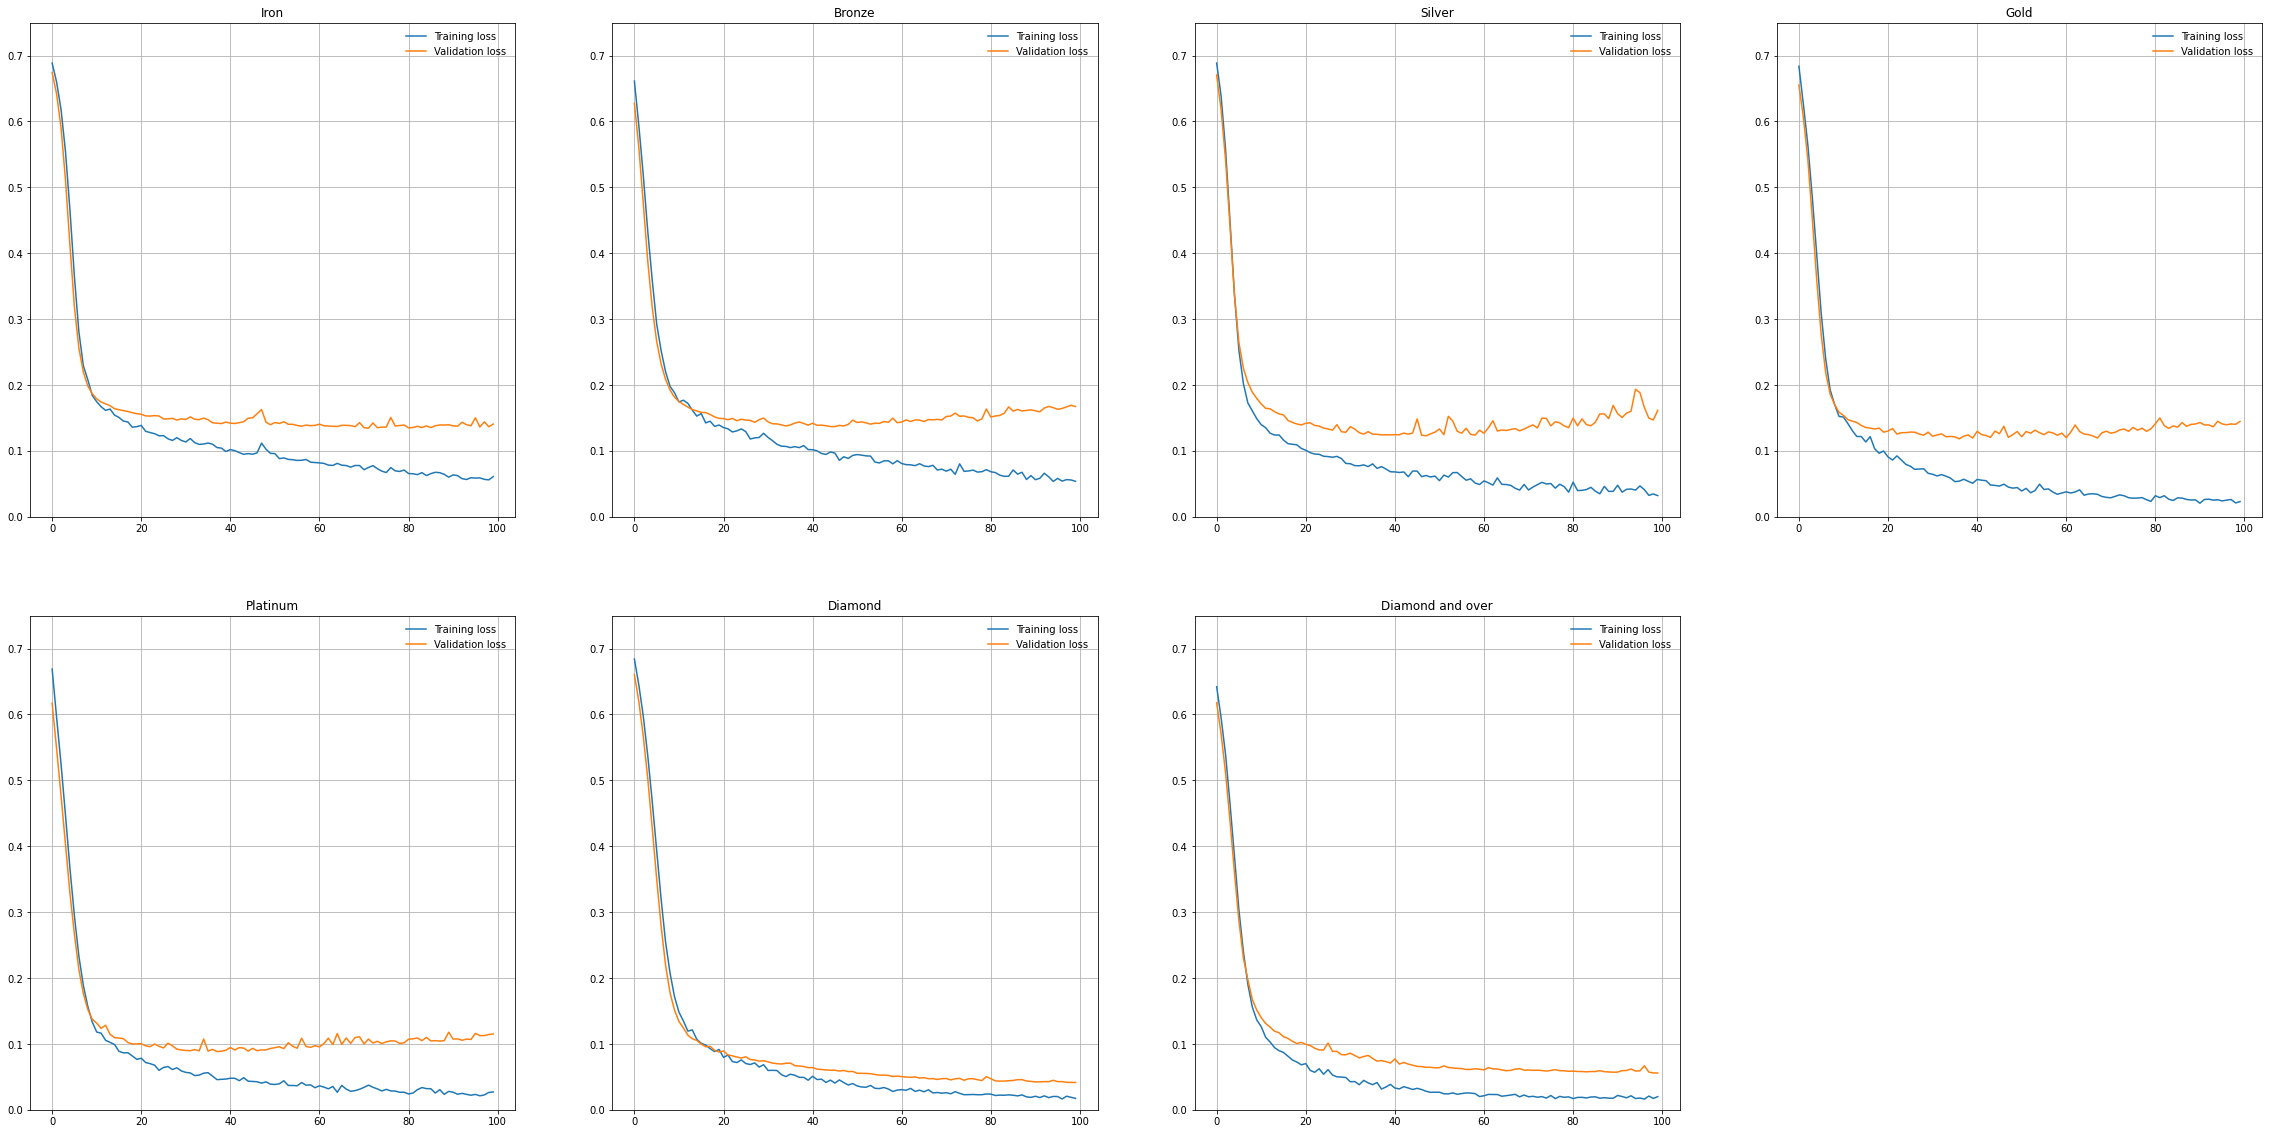

In [277]:
# try - 1

plt.figure(figsize = (40,20))
plt.subplot(2,4,1)
plt.plot(train_losses_iron, label='Training loss')
plt.plot(valid_losses_iron, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Iron")
plt.grid(True)

plt.subplot(2,4,2)
plt.plot(train_losses_bronze, label='Training loss')
plt.plot(valid_losses_bronze, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Bronze")
plt.grid(True)

plt.subplot(2,4,3)
plt.plot(train_losses_silver, label='Training loss')
plt.plot(valid_losses_silver, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Silver")
plt.grid(True)

plt.subplot(2,4,4)
plt.plot(train_losses_gold, label='Training loss')
plt.plot(valid_losses_gold, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Gold")
plt.grid(True)

plt.subplot(2,4,5)
plt.plot(train_losses_platinum, label='Training loss')
plt.plot(valid_losses_platinum, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Platinum")
plt.grid(True)

plt.subplot(2,4,6)
plt.plot(train_losses_diamond, label='Training loss')
plt.plot(valid_losses_diamond, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Diamond")
plt.grid(True)

plt.subplot(2,4,7)
plt.plot(train_losses_over_diamond, label='Training loss')
plt.plot(valid_losses_over_diamond, label='Validation loss')
plt.ylim(0, 0.75)
plt.legend(frameon=False)
plt.title("Diamond and over")
plt.grid(True)

plt.savefig('try-1.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

In [ ]:
def test(test_loader, model, criterion, use_cuda):

    # test loss 를 만들어 줍니다.
    test_loss = 0.0

    # 분류를 성공한 개수를 알려줄 class_correct를 만들어 줍니다.
    class_correct = list(0. for i in range(2))
    
    # image의 개수를 count하기위해 class_total을 만들어 줍니다.
    class_total = list(0. for i in range(2))

    # parameter들을 업데이트 하지 않기 때문에 model.eval()
    model.eval()
    
    # testloader에서 image와 label을 가져 옵니다.
    for data, target in test_loader:
    
        # CUDA가 사용 가능하다면, GPU로 가져온 data를 옮깁니다.
        if use_cuda:
            data, target = data.cuda(), target.cuda()
    
        # forward pass: model에 image 를 넣고, 결과값을 output에 저장 
        output = model(data)
    
        # batch의 loss를 계산합니다.
        loss = criterion(output, target)
    
        # batch의 loss를 통해 test loss를 update해 줍니다. 
        test_loss += loss.item()*data.size(0)
    
        # batch 단위로 output의 값의 index를 pred에 저장합니다. (class에 해당합니다.)
        _, pred = torch.max(output, 1)  
        
        # pred의 값이 목적값이랑 같다면 true를, 아니라면 false를 correct_tensor에 저장
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        # tensor -> numpy
        correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
        
        # test set의 정확도를 계산
        batch_size = len(target.data)
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # 지금까지 더해왔던 test loss의 평균
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    # test 결과 출력
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [272]:
print('-------------------------------------------------------------------')
print('Iron')
test(iron_test, net_iron, criterion_iron, use_cuda)
print('-------------------------------------------------------------------')
print('Bronze')
test(bronze_test, net_bronze, criterion_bronze, use_cuda)
print('-------------------------------------------------------------------')
print('Silver')
test(silver_test, net_silver, criterion_silver, use_cuda)
print('-------------------------------------------------------------------')
print('Gold')
test(gold_test, net_gold, criterion_gold, use_cuda)
print('-------------------------------------------------------------------')
print('Platinum')
test(platinum_test, net_platinum, criterion_platinum, use_cuda)
print('-------------------------------------------------------------------')
print('Diamond')
test(diamond_test, net_diamond, criterion_diamond, use_cuda)
print('-------------------------------------------------------------------')
print('Over Diamond')
test(over_diamond_test, net_over_diamond, criterion_over_diamond, use_cuda)


-------------------------------------------------------------------
Iron
Test Loss: 0.123322


Test Accuracy (Overall): 94% (535/568)
-------------------------------------------------------------------
Bronze
Test Loss: 0.209957


Test Accuracy (Overall): 92% (562/606)
-------------------------------------------------------------------
Silver
Test Loss: 0.121478


Test Accuracy (Overall): 94% (564/598)
-------------------------------------------------------------------
Gold
Test Loss: 0.107683


Test Accuracy (Overall): 95% (513/538)
-------------------------------------------------------------------
Platinum
Test Loss: 0.126085


Test Accuracy (Overall): 93% (552/588)
-------------------------------------------------------------------
Diamond
Test Loss: 0.228883


Test Accuracy (Overall): 94% (401/424)
-------------------------------------------------------------------
Over Diamond
Test Loss: 0.184762


Test Accuracy (Overall): 93% (358/384)


In [273]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict(tensor, model, save_path, mean, std):
    model.load_state_dict(torch.load(save_path)) 
    tensor = tensor - (torch.tensor(mean)[1:])        
    tensor = tensor / (torch.tensor(std)[1:])
    if use_cuda:
        tensor = tensor.to(device)
    with torch.no_grad():
        output = F.log_softmax(model(tensor), dim=0)
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=0)
    ans = ['패배', '승리']
    print(ans[top_class]+ '확률 : {0:.2f}'.format(float(ps[top_class]*100)))
    

In [274]:
print('Iron - mean')
predict(torch.tensor(iron_mean)[1:], model_iron, save_path_iron, iron_mean, iron_std)
print('Bronze - mean')
predict(torch.tensor(bronze_mean)[1:], model_bronze, save_path_bronze, bronze_mean, bronze_std)
print('Silver - mean')
predict(torch.tensor(silver_mean)[1:], model_silver, save_path_silver, silver_mean, silver_std)
print('Gold - mean')
predict(torch.tensor(gold_mean)[1:], model_gold, save_path_gold, gold_mean, gold_std)
print('Platinum - mean')
predict(torch.tensor(platinum_mean)[1:], model_platinum, save_path_platinum, platinum_mean, platinum_std)

Iron - mean
승리확률 : 80.77
Bronze - mean
패배확률 : 51.64
Silver - mean
승리확률 : 75.49
Gold - mean
승리확률 : 79.49
Platinum - mean
승리확률 : 70.89


In [258]:
inputdata = torch.zeros(53)
predict(inputdata, model_bronze, save_path_bronze, bronze_mean, bronze_std)
predict(inputdata, model_silver, save_path_silver, silver_mean, silver_std)
predict(inputdata, model_gold, save_path_gold, gold_mean, gold_std)
predict(inputdata, model_platinum, save_path_platinum, platinum_mean, platinum_std)


승리확률 : 58.03
승리확률 : 58.35
패배확률 : 61.64
패배확률 : 53.04


tensor([5.0000e-01, 1.6454e+03, 2.8190e+01, 2.8361e+01, 3.3315e+01, 1.3370e+01,
        6.5147e+00, 6.2055e+00, 2.8299e+03, 2.7104e+00, 4.3252e-01, 7.8528e-02,
        1.6564e-02, 4.5636e+05, 1.2433e+05, 2.9391e+05, 3.8124e+04, 8.2464e+02,
        7.5014e+04, 2.7749e+04, 4.1870e+04, 5.3919e+03, 2.7508e+04, 7.9920e+00,
        7.4392e+04, 3.5479e+04, 8.2386e+01, 9.8566e+01, 1.0089e+05, 2.9515e+04,
        6.5717e+04, 5.6489e+03, 4.7558e+04, 4.3510e+04, 6.2699e-01, 4.2789e+02,
        1.2593e+02, 7.9767e+01, 1.5160e+01, 8.3594e+02, 6.4029e+01, 5.1748e+00,
        3.8854e+01, 6.2215e+00, 4.9571e-01, 4.7853e-01, 3.4172e-01, 1.8589e-01,
        4.8589e-01, 4.0245e-01, 6.5337e-01, 2.5092e-01, 1.6558e+00, 5.4294e-01])